
# Advanced Data Mining for Data-Driven Insights and Predictive Modeling  
## Deliverable 3: Classification, Clustering, and Pattern Mining

**Course:** MSCS 634  
**Deliverable:** 3  
**Focus:** Classification, clustering, and Pattern Discovery



## 1. Import Libraries


In [212]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules



## 2. Load and Prepare Dataset
(Reuse the cleaned dataset from Deliverable 2)


In [213]:

# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Handle missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Drop Cabin due to excessive missing values
df = df.drop(columns=['Cabin'])

# Remove duplicates
df = df.drop_duplicates()



## 3. Feature Engineering
### 3.1 One-Hot Encoding


In [214]:

# Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)



### 3.2 Create New Features


In [215]:

# Create FamilySize feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Create IsAlone feature
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)



## 4. Classification Models
We will predict Survived as the target


In [216]:

# Drop non-numeric or irrelevant columns
df_model = df.drop(columns=['Name', 'Ticket'])

# Define target and features
X = df_model.drop(columns=['Survived'])
y = df_model['Survived']



### 4.1 Train-Test Split


In [217]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



### 4.2 Feature Scaling


In [218]:

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### 5. Model 1: Decision Tree


In [219]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", acc_dt)
print("Decision Tree F1 Score:", f1_dt)


Decision Tree Accuracy: 0.7262569832402235
Decision Tree F1 Score: 0.6666666666666666



## 6. Model 2: k-Nearest Neighbors (k-NN)


In [220]:

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("KNN Accuracy:", acc_knn)
print("KNN F1 Score:", f1_knn)


KNN Accuracy: 0.8212290502793296
KNN F1 Score: 0.7746478873239436



## 7. Hyperparameter Tuning (Decision Tree)
Using GridSearchCV:


In [221]:

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)

grid_search.fit(X_train_scaled, y_train)

best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 3, 'min_samples_split': 2}


Evaluate tuned model:

In [222]:

y_pred_best_dt = best_dt.predict(X_test_scaled)

acc_best_dt = accuracy_score(y_test, y_pred_best_dt)
f1_best_dt = f1_score(y_test, y_pred_best_dt)

print("Tuned Decision Tree Accuracy:", acc_best_dt)
print("Tuned Decision Tree F1 Score:", f1_best_dt)


Tuned Decision Tree Accuracy: 0.7988826815642458
Tuned Decision Tree F1 Score: 0.7391304347826086



## 8. Confusion Matrix


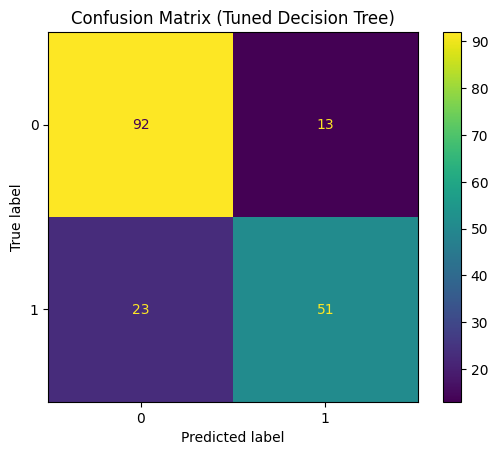

In [223]:

cm = confusion_matrix(y_test, y_pred_best_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Tuned Decision Tree)")
plt.show()



## 9. ROC Curve

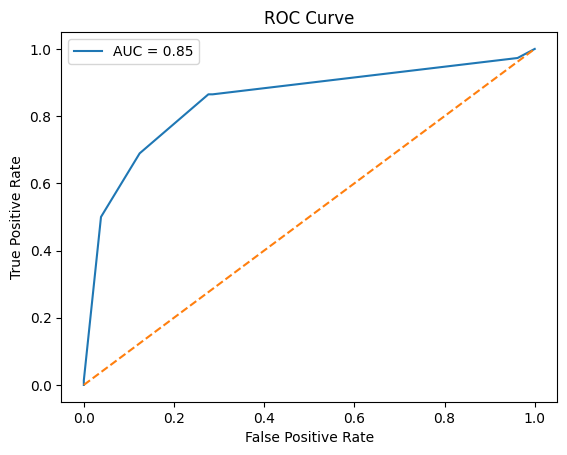

In [224]:

y_probs = best_dt.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



## 10. Model Comparison Table


In [225]:

results = pd.DataFrame({
    "Model": ["Decision Tree", "KNN", "Tuned Decision Tree"],
    "Accuracy": [acc_dt, acc_knn, acc_best_dt],
    "F1 Score": [f1_dt, f1_knn, f1_best_dt]
})

results


,Model,Accuracy,F1 Score
0,Decision Tree,0.726257,0.666667
1,KNN,0.821229,0.774648
2,Tuned Decision Tree,0.798883,0.739130



## 11. Clustering Model (K-Means)

We will cluster passengers using key numeric features.


In [226]:

cluster_features = df_model[['Age', 'Fare', 'FamilySize', 'Pclass']]
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_features)



### 11.1 Fit K-Means


In [227]:

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)

df_model['Cluster'] = clusters



### 11.2 Visualize Clusters using PCA

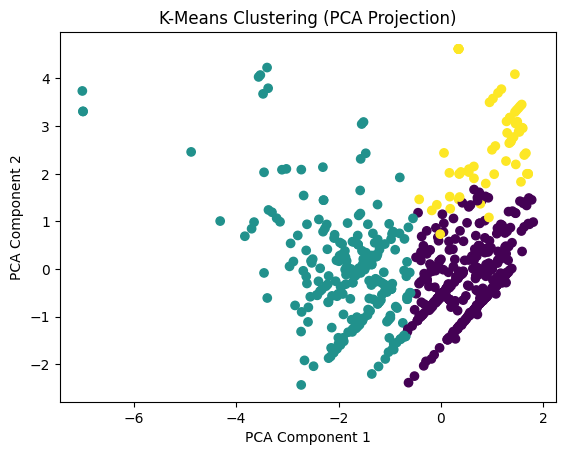

In [228]:

pca = PCA(n_components=2)
pca_components = pca.fit_transform(cluster_scaled)

plt.figure()
plt.scatter(
    pca_components[:, 0],
    pca_components[:, 1],
    c=clusters
)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()



### 11.3 Cluster Summary


In [229]:

cluster_summary = df_model.groupby('Cluster')[['Age', 'Fare', 'FamilySize', 'Pclass']].mean()
cluster_summary


,Age,Fare,FamilySize,Pclass
Cluster,,,,
0,26.976211,12.740224,1.442907,2.747405
1,38.448862,76.921900,1.780488,1.121951
2,16.574627,35.930039,6.343284,2.880597



## 12. Association Rule Mining (Apriori)

### 12.1 Prepare Data
Convert selected features into categorical form:

In [230]:

assoc_df = df[['Survived', 'Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S']].copy()

assoc_df = assoc_df.astype(bool)



### 12.2 Frequent Itemsets


In [231]:

frequent_itemsets = apriori(assoc_df, min_support=0.1, use_colnames=True)
frequent_itemsets


,support,itemsets
0,0.383838,(Survived)
1,1.000000,(Pclass)
2,0.647587,(Sex_male)
3,0.725028,(Embarked_S)
4,0.383838,"(Pclass, Survived)"
5,0.122334,"(Sex_male, Survived)"
6,0.245791,"(Embarked_S, Survived)"
7,0.647587,"(Pclass, Sex_male)"
8,0.725028,"(Embarked_S, Pclass)"
9,0.494949,"(Embarked_S, Sex_male)"



### 12.3 Generate Association Rules


In [232]:

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

# Remove NaN or infinite values
rules = rules.replace([np.inf, -np.inf], np.nan).dropna()

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
1,(Survived),(Embarked_S),0.245791,0.640351,0.883208
2,(Pclass),(Sex_male),0.647587,0.647587,1.000000
5,(Pclass),(Embarked_S),0.725028,0.725028,1.000000
6,(Embarked_S),(Sex_male),0.494949,0.682663,1.054163
7,(Sex_male),(Embarked_S),0.494949,0.764298,1.054163
10,"(Pclass, Survived)",(Embarked_S),0.245791,0.640351,0.883208
11,(Survived),"(Embarked_S, Pclass)",0.245791,0.640351,0.883208
12,"(Embarked_S, Pclass)",(Sex_male),0.494949,0.682663,1.054163
14,"(Pclass, Sex_male)",(Embarked_S),0.494949,0.764298,1.054163
15,(Embarked_S),"(Pclass, Sex_male)",0.494949,0.682663,1.054163



## 13. Insights and Interpretation



### 13.1 Classification Insights

- Decision Tree and KNN both provided reasonable accuracy.
- Hyperparameter tuning improved Decision Tree performance.
- The ROC curve indictes the model's ability to distinguish survivors vs non-survivors.


### 13.2 Clustering Insights
Example interpretation (adjust after seeing your actual results):
- Cluster 0: Lower-class passengers with larger families and lower fares.
- Cluster 1: High fare, upper-class passengers.
- Cluster 3: Younger or mid-fare passengers with small families.

These clusters reveal distinct passengers profiles.

### 13.3 Association Rule Insights
Example patterns:
- Third-class male passengers -> low survival probability.
- First-class or female passengers -> higher survival rates.


## 14. Real-World Applications
- **Classification models** can be used to predict outcomes such as customer churn, loan default or patient survival.
- **Clustering** helps segment customers or detect patterns in user behavior.
- **Association rules** are widely used in:
    - Market basket analysis
    - Recommendation systems
    - Risk detection in finance or healthcare

## 15. Conclusion

In this deliverable, classification, clustering, and association rule mining techniques were applied to the Titanic dataset to uncover predictive and descriptive insights. Decision Tree and k-Nearest Neighbors models were used to predict passenger survival, with hyperparameter tuning improving the Decision Tree’s performance. Evaluation through accuracy, F1 score, confusion matrix, and ROC curve provided a clear view of model effectiveness.

K-Means clustering revealed distinct passenger groups based on fare, class, age, and family size, highlighting natural patterns within the data. Association rule mining further identified meaningful relationships, such as higher survival rates among female and first-class passengers.

Overall, this deliverable demonstrated how different data mining techniques can complement each other to produce both accurate predictions and interpretable real-world insights.